In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nb
import random as rd
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

import cv2
import pydicom
import os
import shutil
import polars as pl
import pydicom
import kaggle_evaluation.rsna_inference_server

import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from typing import Union
from celluloid import Camera
from IPython.display import HTML
from pathlib import Path
from matplotlib import colors
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Part1: Exploratory and Data Analysis

First of all let's explore our data and try to retrieve any useful information from it.

In [10]:
train = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv")
train.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


From the previous output, it is evident that the different aneurysm category increases the sparsity of the DataFrame, which may not provide additional analytical value. Furthermore, *PatientSex* and *Modality* are categorical features that require appropriate encoding. A brief exploratory analysis of these variables is recommended prior to transformation.

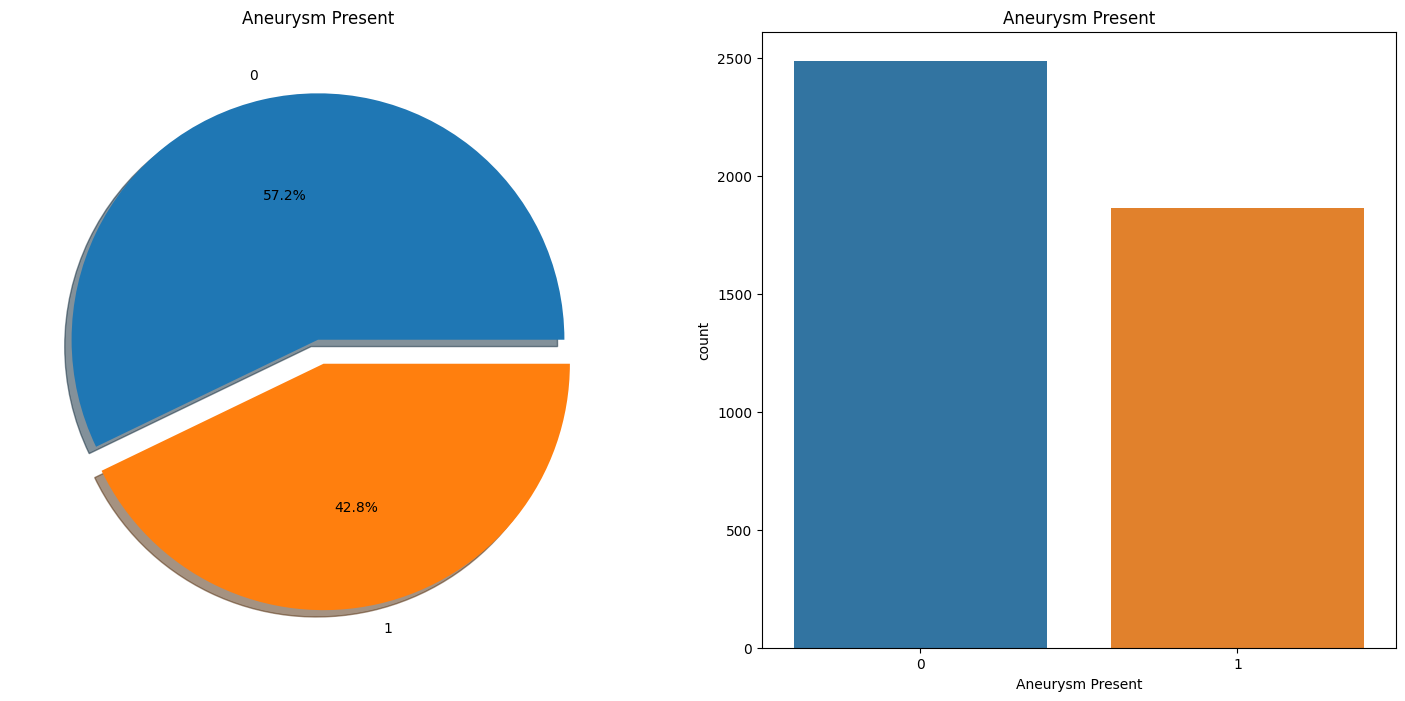

Aneurysm Present,0,1,All
Modality,,,
CTA,835,973,1808
MRA,697,555,1252
MRI T1post,228,77,305
MRI T2,725,258,983
All,2485,1863,4348


In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Aneurysm Present'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Aneurysm Present')
ax[0].set_ylabel('')
sns.countplot(x='Aneurysm Present', data=train)
ax[1].set_title('Aneurysm Present')
plt.show()

pd.crosstab(train['Modality'], train['Aneurysm Present'], margins=True).style.background_gradient(cmap='summer_r')

According to the last figure, only 42.8% of the series instance from the train dataset contain anuerysm presence.

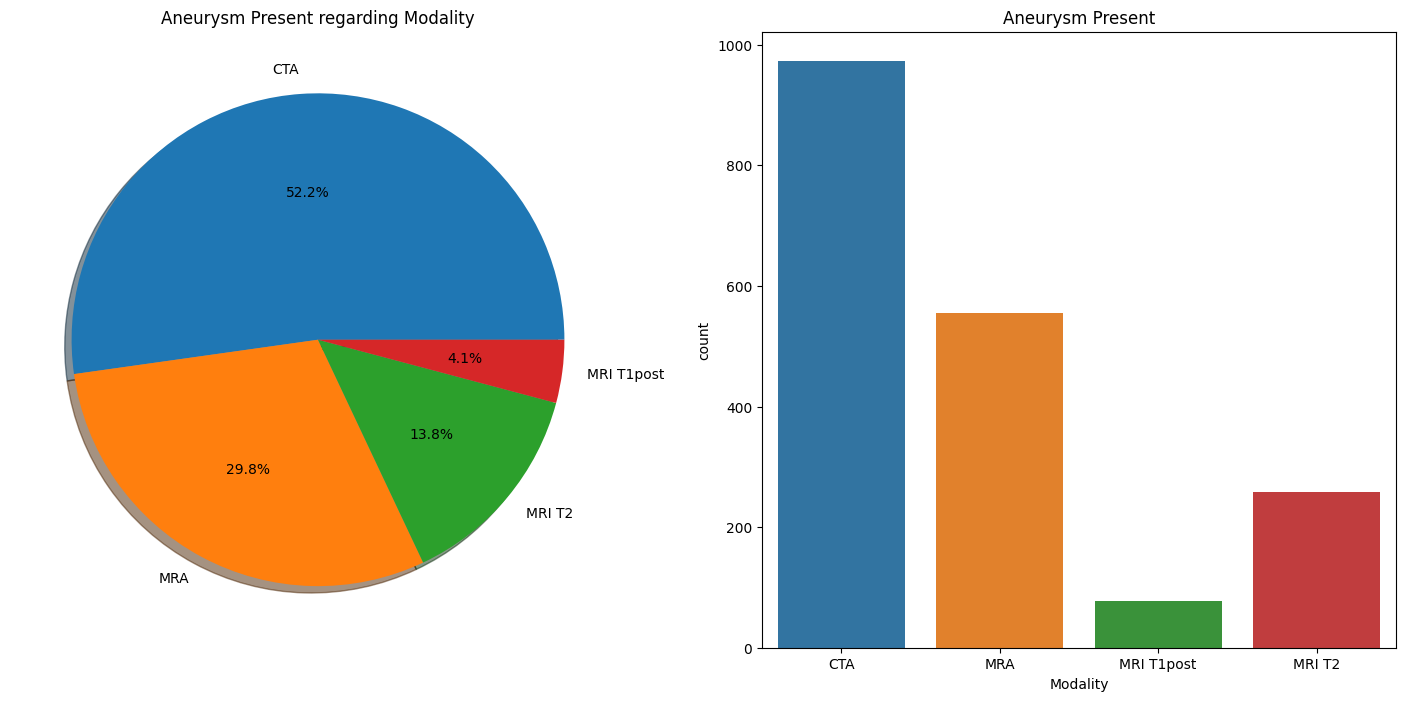

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train.loc[train['Aneurysm Present'] == 1, 'Modality'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Aneurysm Present regarding Modality')
ax[0].set_ylabel('')
sns.countplot(x=train.loc[train['Aneurysm Present'] == 1, 'Modality'])
ax[1].set_title('Aneurysm Present')
plt.show()

In [13]:
print('The oldest individual in the dataset is',train['PatientAge'].max(),'years old while the youngest is',train['PatientAge'].min(),'years old.')
print('The average age of is approximately',int(train['PatientAge'].mean()),'years old')

The oldest individual in the dataset is 89 years old while the youngest is 18 years old.
The average age of is approximately 58 years old


From the previous output, it can be observed that the dataset exhibits a wide age range, which may not be essential for the intended analysis. Therefore, the age values will be categorized into discrete groups based on their unit values.

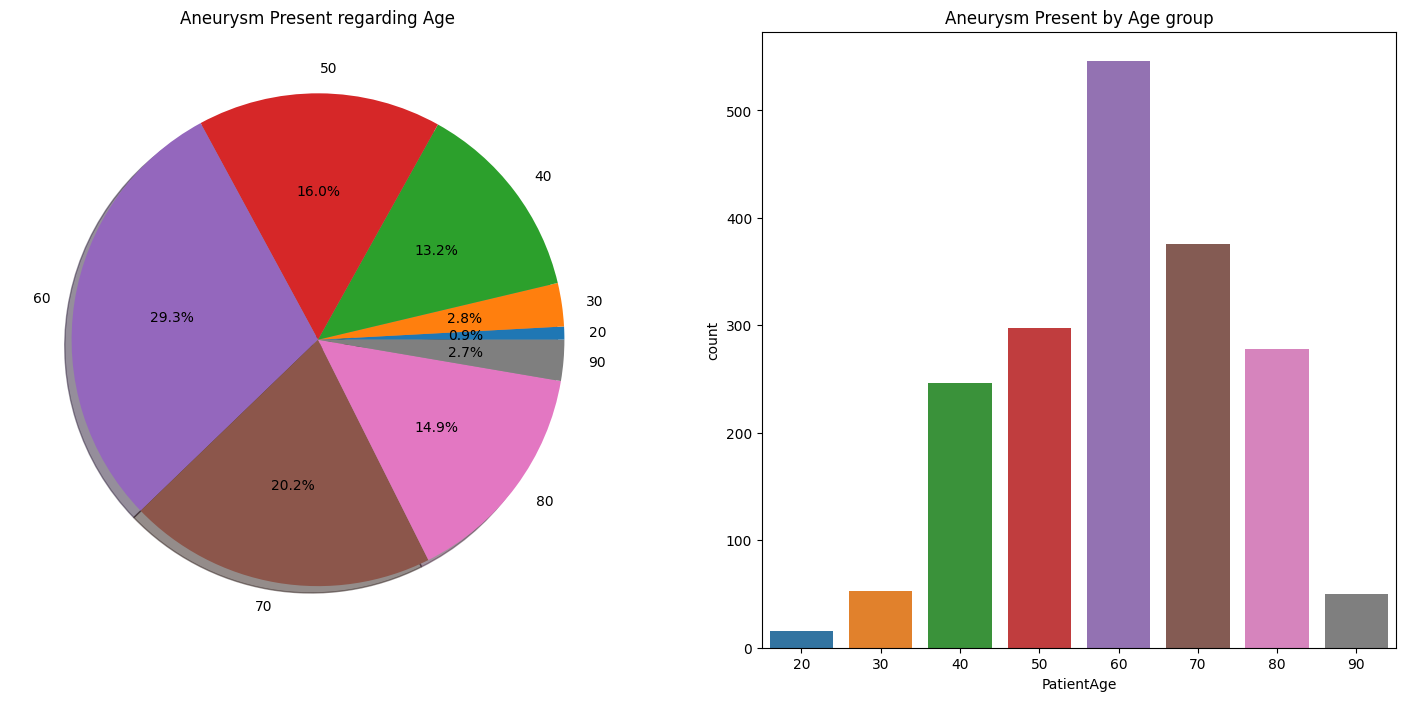

In [14]:
# Categorize age value into discret groups
train['PatientAge'] = train['PatientAge'].apply(lambda x: round(x / 10) * 10)

# Select only the patients with aneurysm
aneurysm_present = train.loc[train['Aneurysm Present'] == 1, 'PatientAge']

# Ccolors for each category and sort categories
categories = sorted(aneurysm_present.unique())
palette = sns.color_palette("tab10", len(categories))
color_map = dict(zip(categories, palette))

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# --- Pie chart ---
aneurysm_present.value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True,
    colors=[color_map[i] for i in sorted(aneurysm_present.unique())]
)
ax[0].set_title('Aneurysm Present regarding Age')
ax[0].set_ylabel('')

# --- Countplot ---
sns.countplot(
    x='PatientAge',
    data=train[train['Aneurysm Present'] == 1],
    order=categories,
    palette=color_map,
    ax=ax[1]
)
ax[1].set_title('Aneurysm Present by Age group')

plt.show()

The age distribution of aneurysm cases reveals a pronounced trend. Individuals in their 60s constitute nearly one-third of the affected population, representing approximately twice the proportion observed in the preceding age group and about 10% more than in the subsequent group. In contrast, the prevalence declines sharply among individuals under 40 years old, who account for only about 4% of the total cases.

In addition to age, sex may also represent a significant variable influencing aneurysm occurrence and should therefore be examined in conjunction with age-related patterns.

In [15]:
# Replace categorical value into float
train['PatientSex'] = train['PatientSex'].replace({'Female': '0', 'Male': '1'})
sex_anr_groupby = train.groupby(['PatientSex', 'Aneurysm Present'])['Aneurysm Present'].count()
sex_anr_crosstab = pd.crosstab(train['PatientSex'], train['Aneurysm Present'], normalize='index') * 100

print(sex_anr_groupby)
sex_anr_crosstab

PatientSex  Aneurysm Present
0           0                   1599
            1                   1406
1           0                    886
            1                    457
Name: Aneurysm Present, dtype: int64


Aneurysm Present,0,1
PatientSex,,
0,53.211314,46.788686
1,65.971705,34.028295


As previously observed, the presence of multiple aneurysm categories increases the sparsity of the dataset. To address this issue, each aneurysm category was encoded as an integer value ranging from 1 to 13, while a value of 0 was assigned to indicate the absence of an aneurysm.

In [16]:
# Initalize the new column 'Category'
train['Category'] = None

columns = list(train.columns)

# Match each aneurysm category with an int value btw [1;13]
col = columns[4:17]  # list of aneurysm category
category = {c:i for c,i in zip(col, range(1,14))}
category['No aneurysm'] = 0
category

{'Left Infraclinoid Internal Carotid Artery': 1,
 'Right Infraclinoid Internal Carotid Artery': 2,
 'Left Supraclinoid Internal Carotid Artery': 3,
 'Right Supraclinoid Internal Carotid Artery': 4,
 'Left Middle Cerebral Artery': 5,
 'Right Middle Cerebral Artery': 6,
 'Anterior Communicating Artery': 7,
 'Left Anterior Cerebral Artery': 8,
 'Right Anterior Cerebral Artery': 9,
 'Left Posterior Communicating Artery': 10,
 'Right Posterior Communicating Artery': 11,
 'Basilar Tip': 12,
 'Other Posterior Circulation': 13,
 'No aneurysm': 0}

In [17]:
# Create a dict storing each index in their respective aneurysm category
# Each keys is the labeled category and the value is a tuple of a list of
# index corresponding to every individuals belonging to the current category
# and the int value of the current category
dico = {}
for c,j, classe in zip(col,range(4, 18), range(1,14)):
    dico[c] = (train.loc[train.iloc[:, j] == 1].index.to_list(), classe)

# Each individuals without aneurysm
no_aneurysm = train.loc[train['Aneurysm Present'] == 0].index.to_list()

In [18]:
# l = list of index
# classe = one of the int value of the dict 'category' defined above
for (l, classe) in dico.values():
    for element in l:
        train.at[element, 'Category'] = classe

for element in no_aneurysm:
    train.at[element, 'Category'] = 0

In [19]:
train = train.drop(columns=list(category.keys())[:13]+['Aneurysm Present'])
train.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Category
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,60,0,MRA,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,80,0,MRA,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,60,1,CTA,13
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,70,1,MRA,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,50,0,MRA,0


# Part2 : Aneurysm vizualisation

## Series images

Next, we examine the train_localizers.csv file, which provides localization data for aneurysms within the training set. For each annotated aneurysm, the file specifies the corresponding image (SOPInstanceUID) and the coordinates approximating the aneurysm’s center.

* SeriesInstanceUID – A unique identifier for each scan series, corresponding to the entries in train.csv.

* SOPInstanceUID – A unique identifier for each individual image within a given series.

* coordinates – The (x, y) coordinates representing the center point of the aneurysm within the image.

* location – A textual description of the aneurysm’s anatomical location.

We now proceed to visualize a selection of these images and overlay bounding boxes centered on the annotated aneurysm coordinates to better understand the localization data.

In [ ]:
from data.process import *

INIT_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
localizer_df = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv")
N = len(localizer_df)  # Number of individuals in localizer_df 

In [ ]:
# Add new column 'Category'
localizer_df['Category'] = None
# Fill up the 'Category' column 
for line in range(N):
    loc = localizer_df.iloc[line,3]
    localizer_df.at[line, 'Category'] = category[loc]
    
localizer_df.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,Category
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,13
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,6
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,6
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery,2
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery,7


(512, 512)


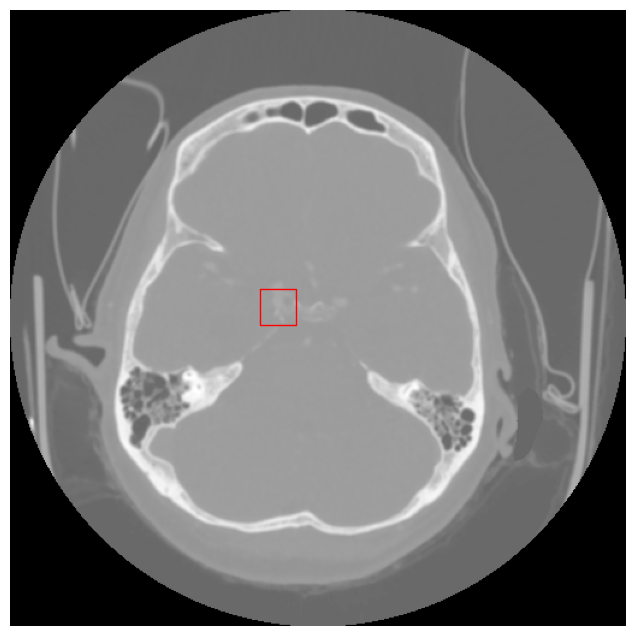

(512, 512)


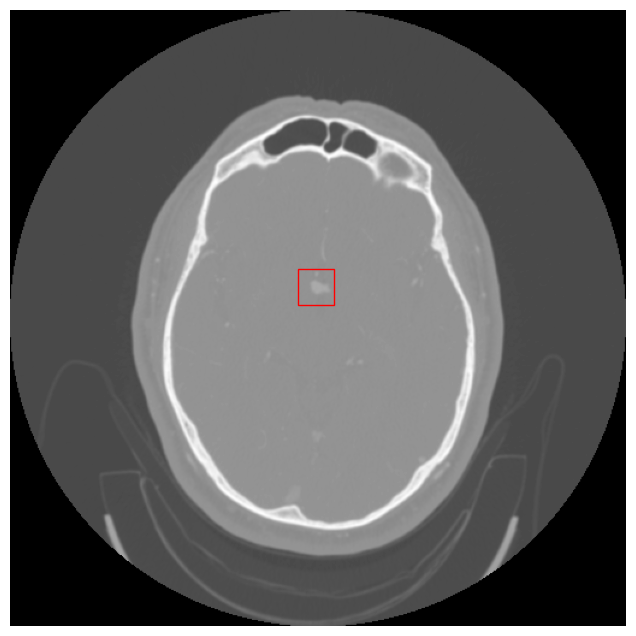

(512, 512)


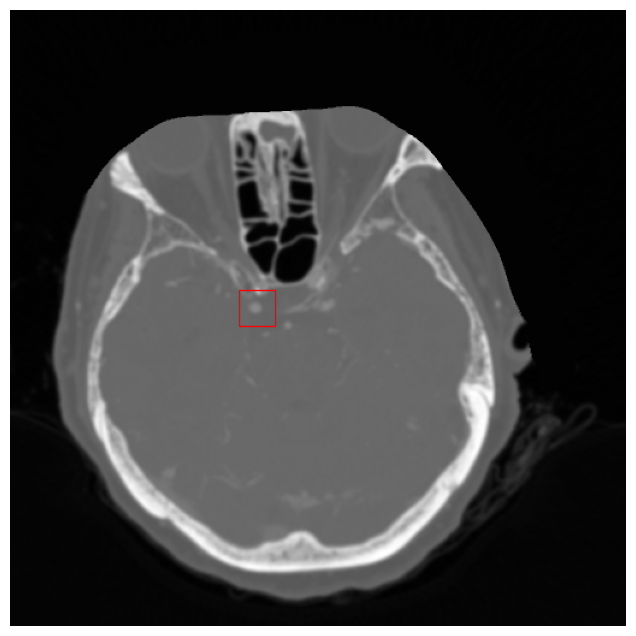

(448, 448)


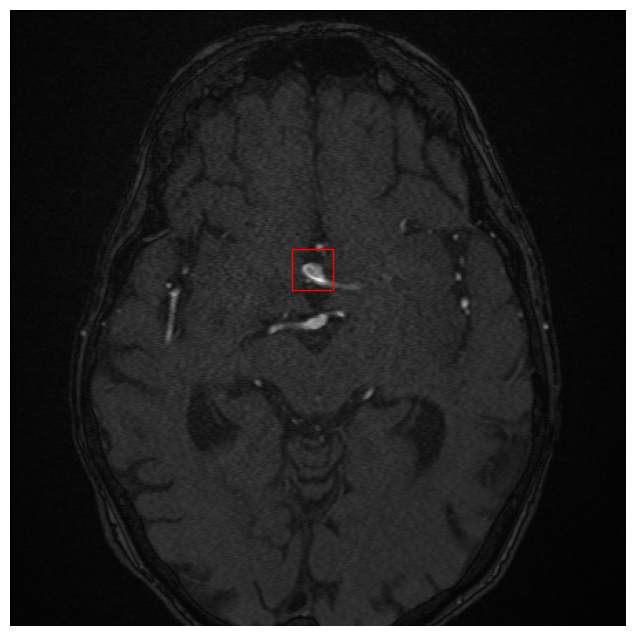

(512, 512)


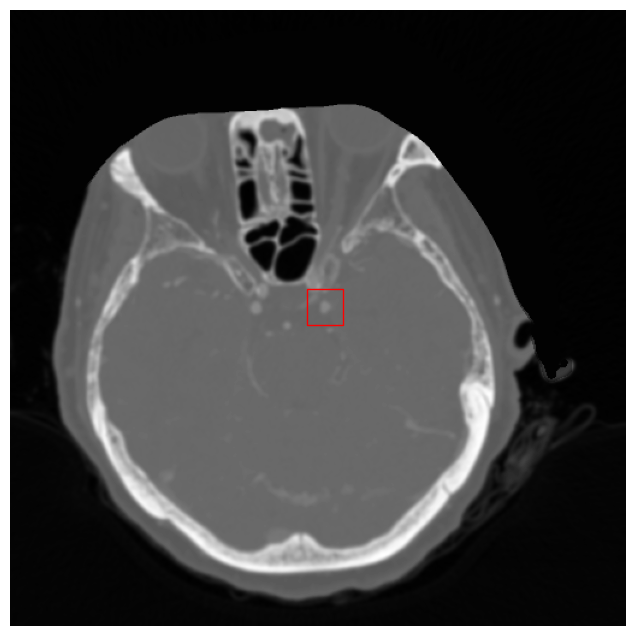

In [21]:
height, width = 30, 30   # height and width of the rectangle
l_rd = [rd.randint(0, 200) for _ in range(5)]  # list of random int

for k in l_rd:
    sr_id, img_id, crd = localizer_df.iloc[k,0], localizer_df.iloc[k,1], localizer_df.iloc[k,2]

    xy,hw = coordinates(crd, height, width)  # coordinates of the center of the aneurysmand coordiantes of the rectangle
    
    image = recup(INIT_PATH, sr_id, img_id)
    
    print(image.shape)
    imshow(image, hw, height, width)

## Segmentations

The *segmentations*/ directory contains NIfTI-format vessel segmentation files corresponding to a subset of the DICOM series found in the *series*/ directory. These segmentations delineate vascular structures and serve as ground-truth annotations for vessel morphology and aneurysm localization within the respective imaging series.

In [22]:
INIT_SEG_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/'
example = '1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381'
ex_df = localizer_df.loc[localizer_df['SeriesInstanceUID'] == example]
ex_df

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,Category
5,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.30083322134992576720...,"{'x': 223.66020358711827, 'y': 225.3447011195274}",Right Anterior Cerebral Artery,9
6,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.46752468449107005352...,"{'x': 289.2376764288231, 'y': 211.78100912436958}",Left Middle Cerebral Artery,5
7,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.14504961303532677815...,"{'x': 232.88987039309842, 'y': 226.4305401310092}",Right Supraclinoid Internal Carotid Artery,4


(512, 512, 228)
Unique labels in segmentation: [ 0  1  2  5  6  7  8  9 10 11 12 13] 12


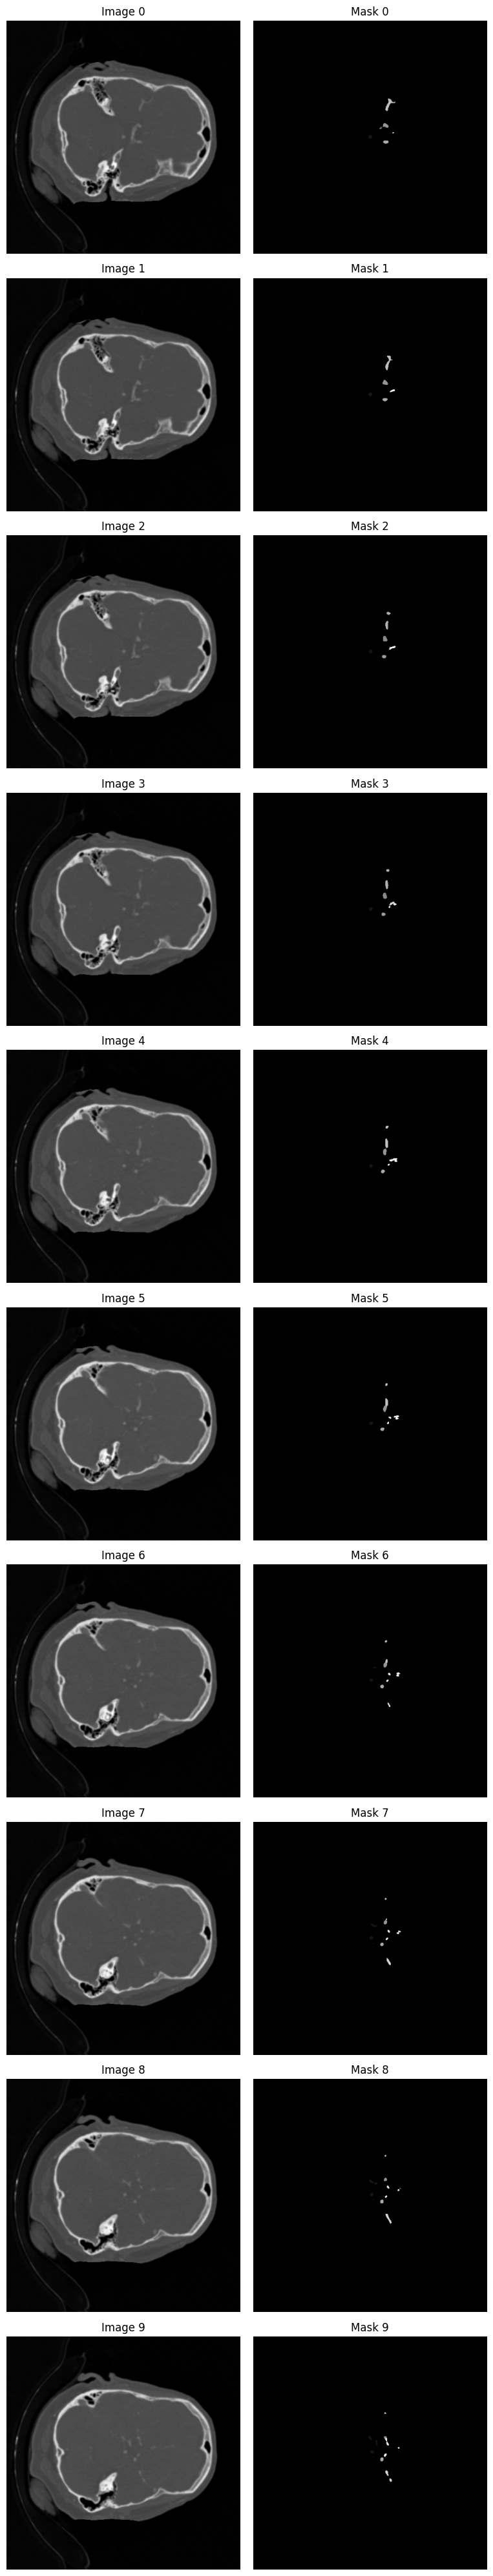

In [23]:
# load and extract 3D numpy array of voxel labels
img, mask = segmentation(INIT_SEG_PATH, example)
unique_labels = np.unique(mask)
print("Unique labels in segmentation:", unique_labels, len(unique_labels))

# Assuming img and mask are 3D arrays: (height, width, slices)
slice_idx = 63  # example slice index

fig, axes = plt.subplots(10, 2, figsize=(8, 40))  # 10 images, each with its mask below

for i in range(10):
    # You can change how slices are selected if needed (e.g., 63 + i)
    axes[i, 0].imshow(img[:, :, slice_idx + i], cmap='gray')
    axes[i, 0].set_title(f'Image {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask[:, :, slice_idx + i], cmap='gray')
    axes[i, 1].set_title(f'Mask {i}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

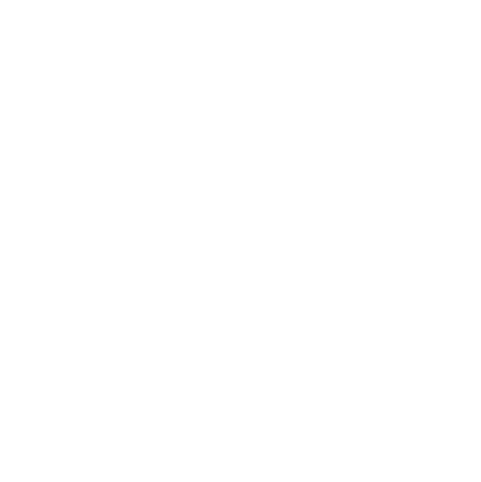

In [24]:
# Define colors: label 0 transparent, labels 1-13 distinct
distinct_colors = [(0,0,0,0), "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4",
                   "#46f0f0", "#f032e6", "#bcf60c", "#fabebe", "#008080", "#e6beff", "#9a6324"]
cmap = colors.ListedColormap(distinct_colors)
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, len(distinct_colors)+0.5, 1), ncolors=len(distinct_colors))

# Animation
fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)

for i in range(img.shape[2]):
    plt.imshow(np.rot90(img[:, :, i]), cmap="gray")
    plt.imshow(np.rot90(mask[:, :, i]), cmap=cmap, alpha=0.7, norm=norm)
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=50)
HTML(animation.to_html5_video())

# Part3 : Model Architecture

In [ ]:
import torch.nn.functional as F
from data.dicom_dataset import AneurysmDataset
from models.uNet.anNet3d import AnNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = AneurysmDataset(INIT_PATH, train)
model = AnNet(in_channels=1).to(device)

In [ ]:
print(dataset[0])
print(dataset[0]['image'].shape)

torch.Size([1, 512, 512, 188])

In [30]:
print(list(dataset[0].keys()))
print(dataset[0]['label'])

['image', 'label', 'modality']
0


In order to detect aneurysm presence in MRI samples, we need to examine each regions of those images. This is why, we opt for the ****image segmentation**** which enable this kind of scrutinizing. Among the various models and techniques of segmentation, we choose an ****U-Net**** architecture which stands out as a ****state of the art solution****.

In [ ]:
vol_expl = dataset[0]['image'].unsqueeze(0)
print("Volume exmaple's shape :", vol_expl.shape)
vol_expl = F.interpolate(
    vol_expl,
    size=(256, 256, 96),  # [D, H, W]
    mode='trilinear',
    align_corners=False
)
print("Volume example's shape after interpolation :", vol_expl.shape)
vol_expl = vol_expl.to(device)  # [N, Channels, Height, Width, Depth]
vol_expl = vol_expl.permute(0, 1, 4, 2, 3)  # [N, Channels, Depth, Height, Width]
print("Volume example's shape after permutation :", vol_expl.shape)

patch_size = 64
outputs = []

for start in range(0, vol_expl.shape[2], patch_size):
    end = min(start + patch_size, vol_expl.shape[2])
    patch = vol_expl[:, :, start:end, :, :]

    with torch.no_grad():
        clf_logits, segmentation = model(patch)
        print(type(clf_logits), type(segmentation))
        print(segmentation.shape)
        clf_prob = torch.sigmoid(clf_logits)
        print("Classification probabilities :", clf_prob)

print(type(outputs))
print(len(outputs))

Volume exmaple's shape : torch.Size([1, 1, 512, 512, 188])
Volume example's shape after interpolation : torch.Size([1, 1, 256, 256, 96])
Volume example's shape after permutation : torch.Size([1, 1, 96, 256, 256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 1, 64, 256, 256])
Classification probabilities : tensor([[0.5077]], device='cuda:0')
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 1, 32, 256, 256])
Classification probabilities : tensor([[0.5074]], device='cuda:0')
<class 'list'>
0


### Training the model

In [ ]:
# EPOCHS = 10

# train_losses = []
# train_dcs = []
# val_losses = []
# val_dcs = []

# for epoch in tqdm(range(EPOCHS)):
#     model.train()
#     train_running_loss = 0
#     train_running_dc = 0
    
#     for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
#         img = img_mask[0].float().to(device)
#         mask = img_mask[1].float().to(device)
        
#         y_pred = model(img)
#         optimizer.zero_grad()
        
#         dc = dice_coefficient(y_pred, mask)
#         loss = criterion(y_pred, mask)
        
#         train_running_loss += loss.item()
#         train_running_dc += dc.item()

#         loss.backward()
#         optimizer.step()

#     train_loss = train_running_loss / (idx + 1)
#     train_dc = train_running_dc / (idx + 1)
    
#     train_losses.append(train_loss)
#     train_dcs.append(train_dc)

#     model.eval()
#     val_running_loss = 0
#     val_running_dc = 0
    
#     with torch.no_grad():
#         for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
#             img = img_mask[0].float().to(device)
#             mask = img_mask[1].float().to(device)

#             y_pred = model(img)
#             loss = criterion(y_pred, mask)
#             dc = dice_coefficient(y_pred, mask)
            
#             val_running_loss += loss.item()
#             val_running_dc += dc.item()

#         val_loss = val_running_loss / (idx + 1)
#         val_dc = val_running_dc / (idx + 1)
    
#     val_losses.append(val_loss)
#     val_dcs.append(val_dc)

#     print("-" * 30)
#     print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
#     print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
#     print("\n")
#     print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
#     print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
#     print("-" * 30)

# # Saving the model
# torch.save(model.state_dict(), 'my_checkpoint.pth')

# Prediction

In [ ]:
# def predict(series_path: str) -> pl.DataFrame | pd.DataFrame:
#     """Make a prediction."""
#     # --------- Replace this section with your own prediction code ---------
#     series_id = os.path.basename(series_path)
    
#     all_filepaths = []
#     for root, _, files in os.walk(series_path):
#         for file in files:
#             if file.endswith('.dcm'):
#                 all_filepaths.append(os.path.join(root, file))
#     all_filepaths.sort()
    
#     # Collect tags from the dicoms
#     tags = defaultdict(list)
#     tags['SeriesInstanceUID'] = series_id
#     global dcms
#     for filepath in all_filepaths:
#         ds = pydicom.dcmread(filepath, force=True)
#         tags['filepath'].append(filepath)
#         for tag in DICOM_TAG_ALLOWLIST:
#             tags[tag].append(getattr(ds, tag, None))
#         # The image is in ds.PixelData

#     # ... do some machine learning magic ...
#     predictions = pl.DataFrame(
#         data=[[series_id] + [0.5] * len(LABEL_COLS)],
#         schema=[ID_COL, *LABEL_COLS],
#         orient='row',
#     )
#     # ----------------------------------------------------------------------

#     if isinstance(predictions, pl.DataFrame):
#         assert predictions.columns == [ID_COL, *LABEL_COLS]
#     elif isinstance(predictions, pd.DataFrame):
#         assert (predictions.columns == [ID_COL, *LABEL_COLS]).all()
#     else:
#         raise TypeError('The predict function must return a DataFrame')

#     # ----------------------------- IMPORTANT ------------------------------
#     # You MUST have the following code in your `predict` function
#     # to prevent "out of disk space" errors. This is a temporary workaround
#     # as we implement improvements to our evaluation system.
#     shutil.rmtree('/kaggle/shared', ignore_errors=True)
#     # ----------------------------------------------------------------------
    
#     return predictions.drop(ID_COL)